In [1]:
import os
import matplotlib
import specutils
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, FormatStrFormatter, AutoMinorLocator
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)
import astropy.io.fits as fits
import numpy as np
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy.convolution import Box1DKernel
from specutils.manipulation import median_smooth
import fnmatch
import pandas as pd
import math


# Show the plots in the notebook
%matplotlib inline

In [2]:
import csv
from astropy import units as u
from specutils.analysis import snr_derived
from specutils import SpectralRegion, Spectrum1D

# Step 1: Read the CSV files and store the data for each observation
observations = []
observation_files = []

# Interactive input for observation filepaths
print("Input your observation filepaths, then write DONE when finished.")

while True:
    file_path = input("Enter an observation filepath (or DONE to finish): ")
    if file_path == "DONE":
        break
    observation_files.append(file_path)

for file_path in observation_files:
    observation_data = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter=' ')
        next(reader)  # Skip header row
        for row in reader:
            wavelength = float(row[0])
            flux = float(row[1])
            observation_data.append((wavelength, flux))
    spectrum = Spectrum1D(spectral_axis=u.Quantity([row[0] for row in observation_data], unit=u.AA),
                          flux=u.Quantity([row[1] for row in observation_data], unit='erg/s/cm2/A'))
    observations.append(spectrum)

Input your observation filepaths, then write DONE when finished.
Enter an observation filepath (or DONE to finish): C:\Users\13zac\OneDrive\Desktop\Research\Data\J0832\mods2b\Science\spec1d_masterobjectmods2b.20191219.0065-J0832+23_MODS2B_20191219T110420.467 - Cropped.fits
Enter an observation filepath (or DONE to finish): C:\Users\13zac\OneDrive\Desktop\Research\Data\J0832\mods2b\Science\spec1d_masterobjectmods2b.20191219.0066-J0832+23_MODS2B_20191219T111006.758 - Cropped.fits
Enter an observation filepath (or DONE to finish): C:\Users\13zac\OneDrive\Desktop\Research\Data\J0832\mods2b\Science\spec1d_masterobjectmods2b.20191219.0067-J0832+23_MODS2B_20191219T111602.208 - Cropped.fits
Enter an observation filepath (or DONE to finish): DONE


UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 6226: character maps to <undefined>

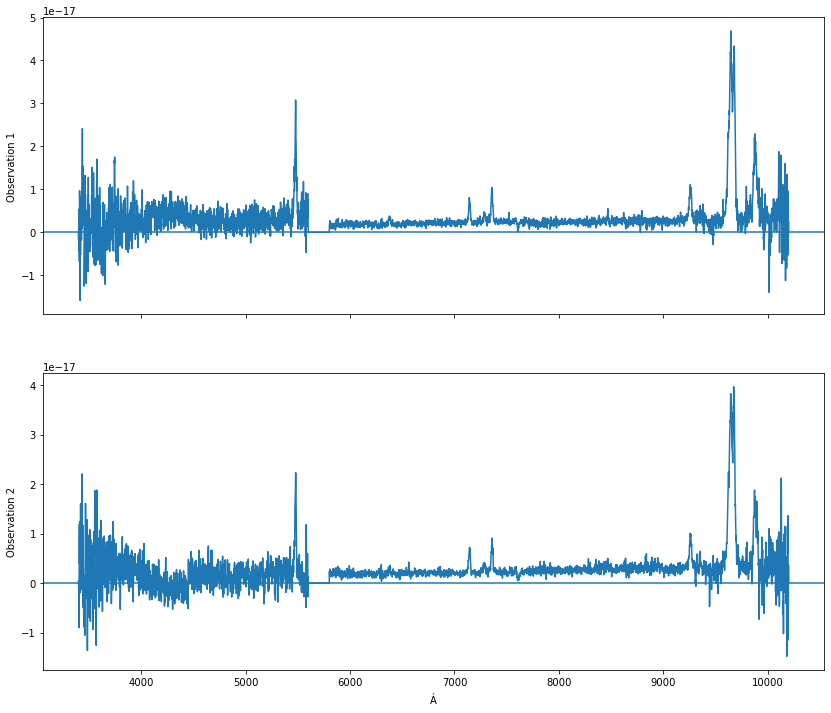

In [9]:
num_plots = len(observations)
fig, axs = plt.subplots(num_plots, 1, figsize=(14, 6*num_plots), sharex=True)

# Plot each spectrum in the observations list
for i, spectrum in enumerate(observations):
    axs[i].plot(spectrum.spectral_axis, spectrum.flux)
    axs[i].set_ylabel(f'Observation {i+1}')
    axs[i].axhline(y=0)

In [10]:
# Step 2: Calculate the SNR for each observation within the desired wavelength region
SNRs = []

for spectrum in observations:
    SNR = snr_derived(spectrum, region=SpectralRegion(5800 * u.AA, 6200 * u.AA))
    print(SNR)
    SNRs.append(SNR)

print("------------------------")    
    
# Step 3: Calculate the weights
weights = []

for SNR in SNRs:
    weight = float(SNR**2) / sum(SNR_i**2 for SNR_i in SNRs)
    print(weight)
    weights.append(weight)

# Step 4: Combine the spectral data using the weighting factors
combined_flux = observations[0].flux * weights[0]

for i in range(1, len(observations)):
    combined_flux += observations[i].flux * weights[i]

combined_spectrum = Spectrum1D(spectral_axis=observations[0].spectral_axis, flux=combined_flux)


3.628798244935353
3.438062345978028
------------------------
0.5269705411925398
0.47302945880746017


Text(0, 0.5, 'Combined Spectrum')

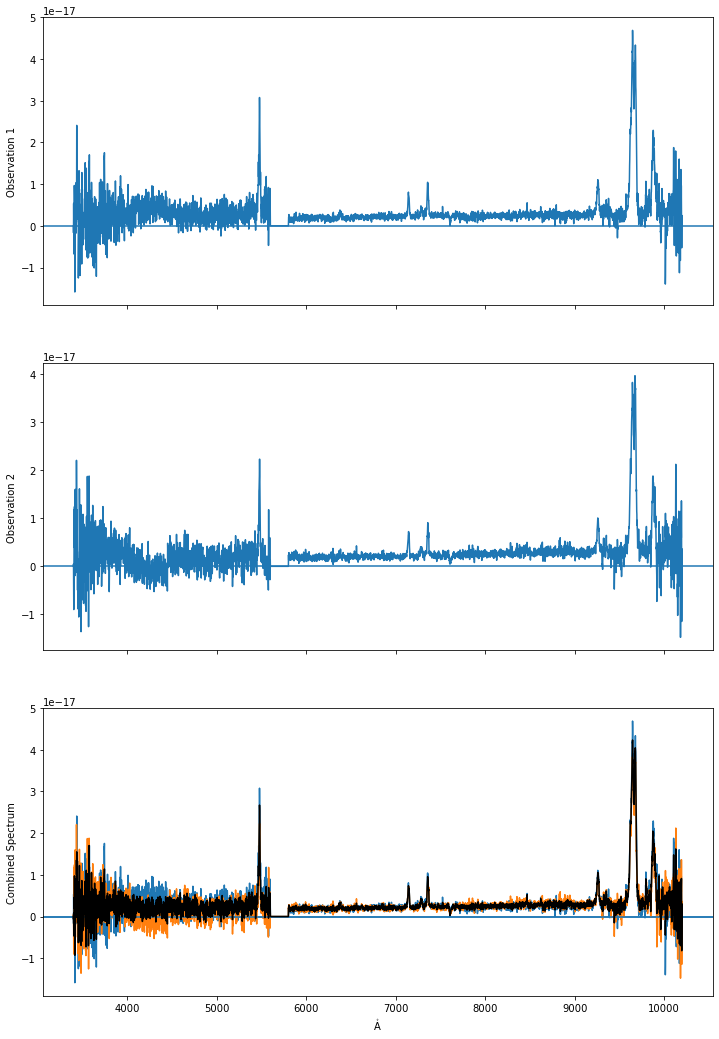

In [11]:
# Step 5: Create subplots for each observation
num_plots = len(observations) +1
fig, axs = plt.subplots(num_plots, 1, figsize=(12, 6*num_plots), sharex=True)

# Plot each spectrum in the observations list
for i, spectrum in enumerate(observations):
    axs[i].plot(spectrum.spectral_axis, spectrum.flux)
    axs[i].set_ylabel(f'Observation {i+1}')
    axs[-1].plot(spectrum.spectral_axis, spectrum.flux)
    axs[i].axhline(y=0)
    axs[-1].axhline(y=0)
#     axs[-1].set_ylim(0,1e-17)

# Plot the combined spectrum
axs[-1].plot(combined_spectrum.spectral_axis, combined_spectrum.flux, color="black")
axs[-1].set_ylabel('Combined Spectrum')

In [12]:
# Step 5: Prompt user for output file path and save the combined data in a new CSV file
output_file_path = input("Enter the output file path for the combined data (e.g., combined_data.csv): ")

with open(output_file_path, 'w', newline='') as file:
    writer = csv.writer(file, delimiter=' ')
    writer.writerow(['Wavelength (Angstroms)', 'Combined Flux (erg/s/cm2/A)'])
    for wavelength, flux in zip(combined_spectrum.spectral_axis, combined_spectrum.flux):
        writer.writerow([f'{wavelength.value:.5f}', f'{flux.value:.5e}'])

print(f"The combined data has been saved to: {output_file_path}")

Enter the output file path for the combined data (e.g., combined_data.csv): C:\Users\13zac\OneDrive\Desktop\Research\Data\WISE 0612 (02-27)\newcombination.csv
The combined data has been saved to: C:\Users\13zac\OneDrive\Desktop\Research\Data\WISE 0612 (02-27)\newcombination.csv


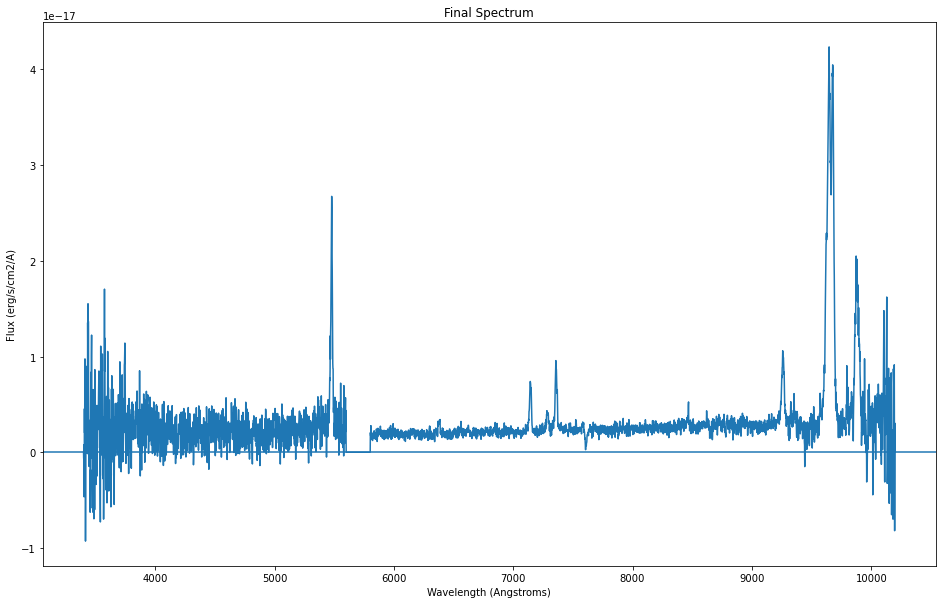

In [13]:
# Step 6: Read the final CSV file and graph its content
final_csv_path = output_file_path

wavelengths = []
fluxes = []

with open(final_csv_path, 'r') as file:
    reader = csv.reader(file, delimiter = ' ')
    next(reader)  # Skip header row
    for row in reader:
        wavelength = float(row[0])
        flux = float(row[1])
        wavelengths.append(wavelength)
        fluxes.append(flux)

# Plot the final spectrum from the CSV file
plt.figure(figsize=(16,10))
plt.plot(wavelengths, fluxes)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm2/A)')
# plt.xlim(6000, 7000)
# plt.ylim(0, 0.4e-15)
plt.axhline(y=0)
plt.title('Final Spectrum')
plt.show()